In [131]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import re

reddit_name = 'infertility'
data = pd.read_csv('./data/reddit/' + reddit_name + '_df')

/Users/divyas/miniconda2/envs/scrape/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,15,61,64,82,86) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [132]:
data.keys()

Index(['Unnamed: 0', 'all_awardings', 'allow_live_comments', 'approved_at_utc',
       'author', 'author_cakeday', 'author_created_utc',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_id', 'author_patreon_flair',
       'author_premium', 'awarders', 'banned_at_utc', 'banned_by',
       'brand_safe', 'can_mod_post', 'contest_mode', 'created_utc',
       'crosspost_parent', 'crosspost_parent_list', 'distinguished', 'domain',
       'edited', 'full_link', 'gilded', 'gildings', 'id', 'is_crosspostable',
       'is_meta', 'is_original_content', 'is_reddit_media_domain',
       'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_template_id', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type',

# Analyzing user flairs

In [147]:
x = list(data['author_flair_text'])
print("Total # users: ",  len(x)) 
x = [g for g in x if (type(g) == str)]
print("Total #  flaired users: ", len(x))
x = list(set(x))
flaired_users = data[data['author_flair_text'].isin(x)]
flaired_users = flaired_users.drop_duplicates(subset='author', keep='first')
x = flaired_users['author_flair_text']
print("Total # unique flaired users: ", len(x))
separated = [re.split(',|\||/', g) for g in x] 

Total # users:  10095
Total #  flaired users:  3364
Total # unique flaired users:  1175


In [156]:
def map_to_binary_var(flair_text, term):
    if term in flair_text.lower():
        return 1
    return 0

treatments = ['iui', 'fet', 'ohss', 'ivf', 'icsi', 'ivm', 'hsg']
preconds = ['pcos', 'endo', 'dor','mf']
for term in treatments:
    flaired_users[term] = flaired_users['author_flair_text'].apply(lambda x: map_to_binary_var(x,term))
for term in preconds:
    flaired_users[term] = flaired_users['author_flair_text'].apply(lambda x: map_to_binary_var(x,term))


In [168]:
np.sum(flaired_users['hsg'])

1

# Distribution of user ages?

# Users with shared ages:  1520
After filtering 'ages' < 20:  1481


Text(0.5, 1.0, 'Distribution of User Ages on r/infertility')

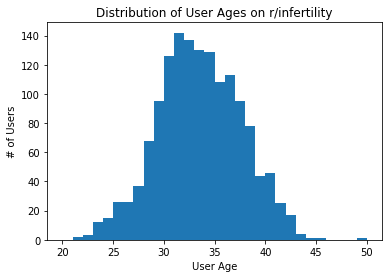

In [134]:
ages = []
for g in separated:
    try: 
        age = int(g[0][:2])
        ages.append(int(g[0][:2]))
    except:
        pass
print("# Users with shared ages: ", len(ages))
ages = [g for g in ages if g > 20]
print("After filtering 'ages' < 20: ", len(ages))

plt.hist(ages, range=(20, 50), bins=30)
plt.xlabel("User Age")
plt.ylabel("# of Users")
plt.title("Distribution of User Ages on r/" + reddit_name)

# Distribution of preconditions + treatments

In [81]:

concatenated_flairs = sum(separated, [])
concatenated_flairs = [g.lower() for g in concatenated_flairs]

treatments = ['iui', 'fet', 'ohss', 'ivf', 'icsi', 'ivm', 'hsg']
preconds = ['pcos', 'endo', 'dor','mf']
print("treatments")
for term in treatments:
    term_list = [g for g in concatenated_flairs if term in g]
    print("Term: ", term, ",", len(term_list))

print("\npreconditions")
for term in preconds:
    term_list = [g for g in concatenated_flairs if term in g]
    print("Term: ", term, ",", len(term_list))

# POF, Endo, DOR, MFI, 
# numbers of IUIs
# FET

treatments
Term:  iui , 611
Term:  fet , 390
Term:  ohss , 3
Term:  ivf , 974
Term:  icsi , 75
Term:  ivm , 1
Term:  hsg , 1

preconditions
Term:  pcos , 300
Term:  endo , 171
Term:  dor , 222
Term:  mf , 480


# Topic modelling for text

In [91]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

newest_doc = data['selftext']

In [92]:
nlp= spacy.load("en")

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

In [93]:
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

In [96]:
doc_list = []
# Iterates through each article in the corpus.
for doc in tqdm(newest_doc):
    # Passes that article through the pipeline and adds to a new list.
    try:
        pr = nlp(doc)
        doc_list.append(pr)
    except:
        print(doc)

/Users/divyas/miniconda2/envs/scrape/lib/python3.5/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan



In [97]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

In [126]:

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=50, 
                                           random_state=2,
                                           update_every=1,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [127]:
print(lda_model.print_topics(num_words=10))

[(0, '0.037*"oop" + 0.030*"neighbor" + 0.029*"movement" + 0.025*"assay" + 0.025*"gt" + 0.024*"ad" + 0.022*"description" + 0.019*"privacy" + 0.015*"capacity" + 0.014*"outlet"'), (4, '0.060*"folk" + 0.058*"spouse" + 0.052*"datum" + 0.047*"interesting" + 0.031*"cvs" + 0.025*"click" + 0.021*"find" + 0.014*"form" + 0.014*"result" + 0.013*"want"'), (49, '0.053*"n" + 0.045*"p" + 0.044*"resolve" + 0.040*"p.m." + 0.038*"movie" + 0.030*"website" + 0.028*"relationship" + 0.027*"lt" + 0.018*"reference" + 0.017*"significantly"'), (13, '0.034*"\n \n " + 0.030*"event" + 0.027*"loan" + 0.027*"vasectomy" + 0.026*"receptive" + 0.025*"approve" + 0.021*"upper" + 0.019*"portion" + 0.018*"ccrm" + 0.016*"proud"'), (30, '0.045*"pee" + 0.026*"room" + 0.024*"season" + 0.024*"joke" + 0.020*"episode" + 0.020*"cat" + 0.019*"\n\n " + 0.019*"haha" + 0.018*"pop" + 0.017*"baby"'), (6, '0.036*"solution" + 0.034*"discussion" + 0.030*"space" + 0.029*"thread" + 0.027*"  " + 0.024*"foster" + 0.024*"imply" + 0.022*"child" +

In [130]:
[print(lda_model.print_topics(num_words=10)[i]) for i in range(50)]

(0, '0.037*"oop" + 0.030*"neighbor" + 0.029*"movement" + 0.025*"assay" + 0.025*"gt" + 0.024*"ad" + 0.022*"description" + 0.019*"privacy" + 0.015*"capacity" + 0.014*"outlet"')
(4, '0.060*"folk" + 0.058*"spouse" + 0.052*"datum" + 0.047*"interesting" + 0.031*"cvs" + 0.025*"click" + 0.021*"find" + 0.014*"form" + 0.014*"result" + 0.013*"want"')
(49, '0.053*"n" + 0.045*"p" + 0.044*"resolve" + 0.040*"p.m." + 0.038*"movie" + 0.030*"website" + 0.028*"relationship" + 0.027*"lt" + 0.018*"reference" + 0.017*"significantly"')
(13, '0.034*"\n \n " + 0.030*"event" + 0.027*"loan" + 0.027*"vasectomy" + 0.026*"receptive" + 0.025*"approve" + 0.021*"upper" + 0.019*"portion" + 0.018*"ccrm" + 0.016*"proud"')
(30, '0.045*"pee" + 0.026*"room" + 0.024*"season" + 0.024*"joke" + 0.020*"episode" + 0.020*"cat" + 0.019*"\n\n " + 0.019*"haha" + 0.018*"pop" + 0.017*"baby"')
(6, '0.036*"solution" + 0.034*"discussion" + 0.030*"space" + 0.029*"thread" + 0.027*"  " + 0.024*"foster" + 0.024*"imply" + 0.022*"child" + 0.022

IndexError: list index out of range

In [ ]:
# include stop words feel, like, infertility, fertility, child, baby
# plot the distribution over different topics
# should get coders? to really look at topics

# Correlations between sentiments of posts and preconditions + treatments

In [169]:
from textblob import TextBlob
def sentiment_calc(text, mode="polarity"):
    try:
        if mode == "polarity":
            return TextBlob(text).sentiment.polarity
        else:
            return TextBlob(text).sentiment.subjectivity
    except:
        return None

flaired_users['sentiment_polarity'] = flaired_users['selftext'].apply(sentiment_calc)
flaired_users['sentiment_subjectivity'] = flaired_users['selftext'].apply(sentiment_calc)

/Users/divyas/miniconda2/envs/scrape/lib/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  indices = f_indices.astype(np.intp)
/Users/divyas/miniconda2/envs/scrape/lib/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  indices[indices == n_equal_bins] -= 1


(array([  2.,   5.,  22.,  57., 147., 444., 306., 124.,  30.,  21.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

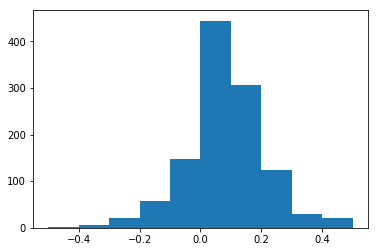

In [172]:
# histogram of sentiments in this dataset (which reddits are more positive than others?)
plt.hist(flaired_users['sentiment_polarity'], range=(-.5, .5), bins=10)

In [180]:
from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [176]:
# Correlations between indicator variables for any preconditions or treatments
# Select subset of users with flairs
# Then create indicator variables for each precondition + treatment
voi = flaired_users[['sentiment_polarity', 
                     'iui', 'fet', 'ohss', 'ivf', 'icsi', 'ivm', 'hsg', 'pcos', 'endo', 'dor','mf']]
voi.corr()

,sentiment_polarity,iui,fet,ohss,ivf,icsi,ivm,hsg,pcos,endo,dor,mf
sentiment_polarity,1.000000,0.028766,-0.002471,0.019849,0.019018,-0.004941,-0.005942,-0.015595,-0.013681,-0.064645,0.022716,-0.013094
iui,0.028766,1.000000,-0.005622,-0.027553,0.082516,-0.070362,0.043738,0.043738,-0.025567,-0.030940,-0.047817,-0.062838
fet,-0.002471,-0.005622,1.000000,-0.018983,0.096547,0.043487,-0.013417,-0.013417,-0.031159,0.006224,-0.054417,0.038160
ohss,0.019849,-0.027553,-0.018983,1.000000,0.004418,-0.008429,-0.001205,-0.001205,0.035905,-0.013271,-0.013666,0.026053
ivf,0.019018,0.082516,0.096547,0.004418,1.000000,0.131036,-0.026229,-0.026229,-0.164491,0.022631,0.121493,0.054952
icsi,-0.004941,-0.070362,0.043487,-0.008429,0.131036,1.000000,-0.005957,-0.005957,-0.046964,-0.020873,-0.023878,0.205823
ivm,-0.005942,0.043738,-0.013417,-0.001205,-0.026229,-0.005957,1.000000,-0.000852,0.064054,-0.009380,-0.009659,-0.016095
hsg,-0.015595,0.043738,-0.013417,-0.001205,-0.026229,-0.005957,-0.000852,1.000000,-0.013298,-0.009380,-0.009659,-0.016095
pcos,-0.013681,-0.025567,-0.031159,0.035905,-0.164491,-0.046964,0.064054,-0.013298,1.000000,0.000692,-0.135676,0.004776
endo,-0.064645,-0.030940,0.006224,-0.013271,0.022631,-0.020873,-0.009380,-0.009380,0.000692,1.000000,0.011170,-0.032135


In [181]:
calculate_pvalues(voi)

,sentiment_polarity,iui,fet,ohss,ivf,icsi,ivm,hsg,pcos,endo,dor,mf
sentiment_polarity,0,0.3258,0.9328,0.4978,0.5159,0.866,0.8392,0.5943,0.6403,0.0271,0.4378,0.6547
iui,0.3258,0,0.9138,0.3465,0.0043,0.0164,0.1331,0.1331,0.399,0.2996,0.0871,0.0292
fet,0.9328,0.9138,0,0.5156,0.0007,0.1365,0.6459,0.6459,0.2849,0.8321,0.0404,0.2338
ohss,0.4978,0.3465,0.5156,0,0.8811,0.7723,0.967,0.967,0.2209,0.6486,0.6421,0.371
ivf,0.5159,0.0043,0.0007,0.8811,0,0,0.3685,0.3685,0,0.4459,0,0.0464
icsi,0.866,0.0164,0.1365,0.7723,0,0,0.8379,0.8379,0.1047,0.4686,0.4272,0
ivm,0.8392,0.1331,0.6459,0.967,0.3685,0.8379,0,0.9767,0.0286,0.7474,0.7425,0.5821
hsg,0.5943,0.1331,0.6459,0.967,0.3685,0.8379,0.9767,0,0.6478,0.7474,0.7425,0.5821
pcos,0.6403,0.399,0.2849,0.2209,0,0.1047,0.0286,0.6478,0,0.9984,0,0.855
endo,0.0271,0.2996,0.8321,0.6486,0.4459,0.4686,0.7474,0.7474,0.9984,0,0.6676,0.2764
